<a href="https://colab.research.google.com/github/jamesBaker361/colab/blob/master/poly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q seaborn

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.14.0


In [0]:
def polynomial(x):
  a1=1
  a2=2
  a3=3
  sum=0
  sum+=a1*x
  sum+=a3* x**2
  return sum

In [55]:
polynomial(1)

4

In [0]:
ar=[]
for _ in range(0,200):
  x=random.randint(-150,150)
  ar.append([x,polynomial(x)])

In [0]:
data=np.array(ar)

In [0]:
dataset = pd.DataFrame({'X':data[:,0],'Y':data[:,1]})

In [59]:
dataset.head()

,X,Y
0,-15,660
1,-9,234
2,-93,25854
3,11,374
4,-46,6302


In [0]:
dataset["X^2"]=dataset["X"]**2

In [61]:
dataset.head()

,X,Y,X^2
0,-15,660,225
1,-9,234,81
2,-93,25854,8649
3,11,374,121
4,-46,6302,2116


In [0]:
#dataset["X^3"]=dataset["X"]**3

In [0]:
#dataset["X^4"]=dataset["X"]**4

In [62]:
dataset.tail()

,X,Y,X^2
195,-42,5250,1764
196,-75,16800,5625
197,-124,46004,15376
198,114,39102,12996
199,-57,9690,3249


now that we have some data, lets separate it into training and testing

In [0]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [64]:
test_dataset.head()

,X,Y,X^2
9,-125,46750,15625
21,8,200,64
25,0,0,0
29,120,43320,14400
31,4,52,16


In [65]:
train_dataset.columns

Index(['X', 'Y', 'X^2'], dtype='object')

In [0]:
train_labels = train_dataset.pop('Y')
test_labels = test_dataset.pop('Y')

In [67]:
test_labels.head()

9     46750
21      200
25        0
29    43320
31       52
Name: Y, dtype: int64

In [68]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
X,160.0,2.7875,81.885285,-150.0,-60.75,3.0,74.25,148.0
X^2,160.0,6671.0625,6426.627407,1.0,900.00,4830.5,11718.25,22500.0


In [0]:
def norm(x,train_stats=train_stats):
  return (x - train_stats['mean']) / train_stats['std']

In [0]:
normed_train_data = train_dataset
normed_test_data = test_dataset

In [71]:
normed_train_data.head()

,X,X^2
18,145,21025
170,-99,9801
107,-130,16900
98,85,7225
177,-57,3249


In [0]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [0]:
model=build_model()

In [74]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,417
Trainable params: 4,417
Non-trainable params: 0
_________________________________________________________________


In [75]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[1184.3254  ],
       [ 520.87286 ],
       [ 905.6522  ],
       [ 413.651   ],
       [ 167.90219 ],
       [ 674.3823  ],
       [ 850.06226 ],
       [ 127.94396 ],
       [  11.712789],
       [ 575.78284 ]], dtype=float32)

In [0]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

In [77]:
EPOCHS=1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [78]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,123.822281,7.295760,123.822281,641.101196,17.932636,641.101196,995
996,3913.236328,39.556900,3913.236328,8325.948242,65.924545,8325.948242,996
997,41032.089600,133.188904,41032.089844,350793.843750,430.443237,350793.843750,997
998,285875.597656,383.145386,285875.593750,75646.531250,199.516129,75646.531250,998
999,13809.606506,64.389130,13809.606445,3763.506348,44.046852,3763.506348,999


In [0]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,20000])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,1000000000])
  plt.legend()
  plt.show()

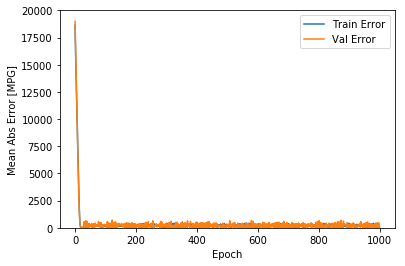

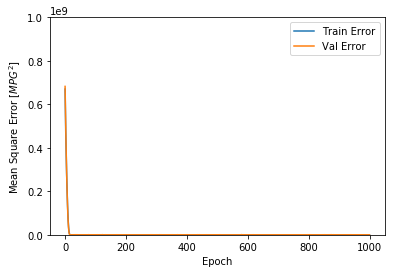

In [84]:
plot_history(history)

In [85]:
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f}".format(mae))

Testing set Mean Abs Error: 36.93


In [0]:
test_predictions = model.predict(test_dataset)

In [87]:
test_predictions

array([[ 4.6838727e+04],
       [ 2.0068358e+02],
       [-7.1332052e-02],
       [ 4.3415078e+04],
       [ 5.2461891e+01],
       [ 1.6540223e+04],
       [ 6.0465371e+04],
       [ 1.2228362e+03],
       [ 1.1250820e+04],
       [ 2.1809479e+04],
       [ 3.2379001e+03],
       [ 4.1982074e+04],
       [ 1.3471283e+03],
       [ 5.8772051e+04],
       [ 1.3164963e+04],
       [ 1.4656610e+04],
       [ 1.5660335e+04],
       [ 3.7498752e+02],
       [ 5.3315809e+04],
       [ 8.8606378e+02],
       [ 2.0068358e+02],
       [ 2.6727930e+03],
       [ 3.5831145e+04],
       [ 1.5229409e+04],
       [ 2.5347041e+04],
       [ 1.8355716e+02],
       [ 3.2624383e+04],
       [ 1.4239822e+04],
       [ 4.8519756e+03],
       [ 1.7050679e+03],
       [ 5.1726488e+04],
       [ 1.3829045e+04],
       [ 5.7102781e+04],
       [ 1.0156231e+02],
       [ 5.0096514e+03],
       [ 1.3829044e+04],
       [ 3.1114873e+03],
       [ 9.4869814e+03],
       [ 1.2228362e+03],
       [ 2.4797984e+04]],

In [92]:
test_labels.array

<PandasArray>
[46750,   200,     0, 43320,    52, 16502, 60350,  1220, 11224, 21760,  3234,
 41890,  1344, 58660, 13134, 14630, 15624,   374, 53200,   884,   200,  2670,
 35752, 15194, 25300,   184, 32552, 14214,  4840,  1704, 51614, 13804, 56994,
   102,  5002, 13804,  3104,  9464,  1220, 24752]
Length: 40, dtype: int64

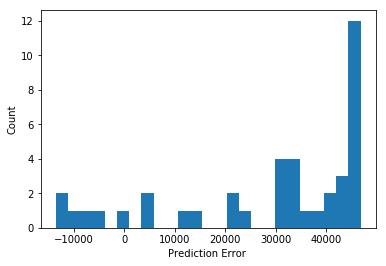

In [94]:
error = test_predictions[0] - test_labels.array
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error ")
_ = plt.ylabel("Count")

9     NaN
21    NaN
25    NaN
29    NaN
31    NaN
32    NaN
36    NaN
39    NaN
47    NaN
58    NaN
67    NaN
70    NaN
72    NaN
77    NaN
79    NaN
81    NaN
82    NaN
87    NaN
88    NaN
99    NaN
103   NaN
114   NaN
115   NaN
117   NaN
127   NaN
140   NaN
142   NaN
147   NaN
148   NaN
151   NaN
165   NaN
166   NaN
169   NaN
172   NaN
174   NaN
176   NaN
188   NaN
190   NaN
192   NaN
193   NaN
Name: Y, dtype: float64

In [0]:
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [0]:
model=build_model()

In [99]:
EPOCHS=1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [100]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,2122.452759,37.821739,2122.452637,1240.990234,30.533854,1240.990234,995
996,1077.939651,25.762238,1077.939697,1109.507812,27.965477,1109.507812,996
997,1115.387558,26.353281,1115.387573,1321.822510,27.500164,1321.822510,997
998,1130.559799,26.349907,1130.559814,1580.631104,30.767696,1580.631104,998
999,1257.927216,28.137466,1257.927246,5364.111816,65.140465,5364.111816,999


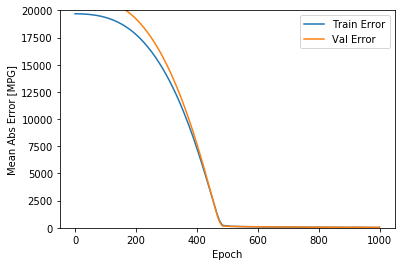

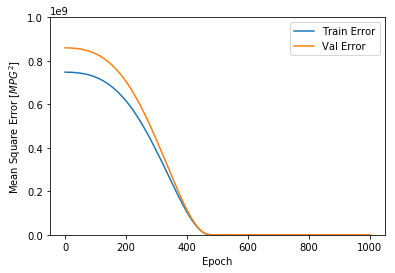

In [101]:
plot_history(history)

In [102]:
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f}".format(mae))

Testing set Mean Abs Error: 115064400.00


In [0]:
test_predictions = model.predict(test_dataset)

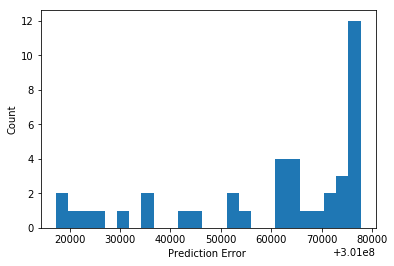

In [105]:
error = test_predictions[0] - test_labels.array
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error ")
_ = plt.ylabel("Count")

In [107]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f}".format(mae))

Testing set Mean Abs Error: 63.02


In [0]:
test_predictions = model.predict(normed_test_data)

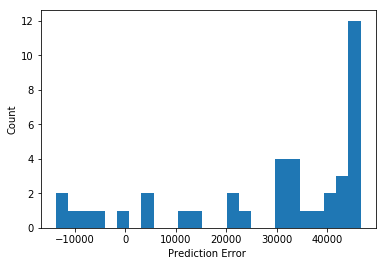

In [112]:
error = test_predictions[0] - test_labels.array
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error ")
_ = plt.ylabel("Count")